In [1]:
# Cell 1: Install dependencies
# Use CUDA 11.8 PyTorch wheels (Colab typically supports these). If it fails, try the pip installs without the extra index.
!pip install -U torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118
!pip install decord==0.6.4 ffmpeg-python tqdm


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!unzip -q /content/drive/MyDrive/Priyanka_Project/NORMAL.zip -d /content
!unzip -q /content/drive/MyDrive/Priyanka_Project/cashlifting.zip -d /content

In [4]:
# Update these to your paths (you said the data is already at these locations)
NORMAL_DIR = "/content/NORAML "          # -> contains 2 x 1hr normal videos (.mp4/.avi/.dav converted to mp4)
CASHLIFT_DIR = "/content/cashlifting"  # -> contains 5 clips (mp4)
OUTPUT_CLIPS_DIR = "/content/clip_dataset"   # where labeled clips will be saved
MODEL_DIR = "/content/drive/MyDrive/cashlift_model"  # save trained model to Drive


import os
os.makedirs(OUTPUT_CLIPS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
print("Paths set. NORMAL_DIR:", NORMAL_DIR, "CASHLIFT_DIR:", CASHLIFT_DIR)

Paths set. NORMAL_DIR: /content/NORAML  CASHLIFT_DIR: /content/cashlifting


In [5]:

import os, subprocess, glob
folders = ["/content/NORMAL", "/content/cashlifting"]
for folder in folders:
    if not os.path.exists(folder):
        continue
    for f in os.listdir(folder):
        if f.lower().endswith(".dav"):
            inpath = os.path.join(folder,f)
            outpath = os.path.join(folder, os.path.splitext(f)[0] + ".mp4")
            if os.path.exists(outpath):
                print("exists", outpath); continue
            cmd = ["ffmpeg","-i", inpath, "-c:v", "libx264", "-preset", "fast", "-crf", "23", outpath, "-y"]
            print("Converting", inpath, "->", outpath)
            subprocess.run(cmd, check=True)
print("Done")



exists /content/cashlifting/cctv_CAM 5_main_20250524212350.mp4
exists /content/cashlifting/cctv_CAM 5_main_20250524212319.mp4
exists /content/cashlifting/cctv_CAM 5_main_20250524212558.mp4
exists /content/cashlifting/cctv_CAM 5_main_20250524212334.mp4
exists /content/cashlifting/cctv_CAM 5_main_20250524212746.mp4
exists /content/cashlifting/cctv_CAM 5_main_20250524212730.mp4
Done


In [ ]:
# ============================
# Optimized GPU Clip Extraction (First 3 min for NORMAL)
# ============================

!pip install ffmpeg-python decord imageio tqdm

import os, uuid, shutil, tempfile
from decord import VideoReader, cpu, gpu
import numpy as np
from tqdm import tqdm
import imageio
import ffmpeg

# ==== CONFIG ====
CLIP_LEN = 5       # seconds
STRIDE = 2         # seconds between clip starts
FPS_TARGET = 15    # fps for output clips
max_normal_clips = 500   # reduce for testing
max_cash_clips = None    # None -> all
MAX_NORMAL_DURATION = 180  # seconds (3 minutes)

# Paths
NORMAL_DIR = "/content/NORAML "
CASHLIFT_DIR = "/content/cashlifting"
OUTPUT_CLIPS_DIR = "/content/clips"

# Output folders
for split in ["train", "val"]:
    for cls in ["normal", "cashlifting"]:
        os.makedirs(os.path.join(OUTPUT_CLIPS_DIR, split, cls), exist_ok=True)

# ============================
# Save clip to disk with low RAM usage
# ============================
def save_clip_frames(frames, out_path, fps=FPS_TARGET):
    tmp_img_dir = tempfile.mkdtemp()
    for i, f in enumerate(frames):
        imageio.imwrite(os.path.join(tmp_img_dir, f"{i:06d}.jpg"), f, quality=90)
    (
        ffmpeg
        .input(os.path.join(tmp_img_dir, '%06d.jpg'), framerate=fps)
        .output(out_path, vcodec='libx264', crf=23, pix_fmt='yuv420p')
        .overwrite_output()
        .run(quiet=True)
    )
    shutil.rmtree(tmp_img_dir)

# ============================
# Extract clips from one video
# ============================
def extract_clips_from_video(video_path, out_dir, clip_len=CLIP_LEN, stride=STRIDE, fps_target=FPS_TARGET, max_clips=None, max_duration=None):
    try:
        vr = VideoReader(video_path, ctx=gpu(0))  # Use GPU decoding
    except:
        vr = VideoReader(video_path, ctx=cpu(0))  # Fallback to CPU if GPU decoding not available

    src_fps = float(vr.get_avg_fps())
    total_frames = len(vr)
    duration = total_frames / src_fps

    # Limit duration if requested
    if max_duration is not None:
        duration = min(duration, max_duration)

    starts = np.arange(0, max(0, duration - clip_len + 1e-3), stride)
    saved = 0

    for s in tqdm(starts, desc=os.path.basename(video_path)):
        if max_clips is not None and saved >= max_clips:
            break

        t0, t1 = s, s + clip_len
        times = np.linspace(t0, t1, int(round(clip_len * fps_target)), endpoint=False)
        idxs = np.clip((times * src_fps).astype(int), 0, total_frames - 1)

        frames = []
        for i in idxs:
            frames.append(vr[i].asnumpy()[:,:,::-1])  # BGR → RGB

        if len(frames) < 3:
            continue

        out_p = os.path.join(out_dir, f"{os.path.splitext(os.path.basename(video_path))[0]}_{int(s)}_{uuid.uuid4().hex[:6]}.mp4")
        save_clip_frames(frames, out_p, fps=fps_target)
        saved += 1

    return saved

# ============================
# Process Videos
# ============================
normal_files = [os.path.join(NORMAL_DIR, f) for f in os.listdir(NORMAL_DIR) if f.lower().endswith((".mp4", ".avi", ".mov"))]
cash_files = [os.path.join(CASHLIFT_DIR, f) for f in os.listdir(CASHLIFT_DIR) if f.lower().endswith((".mp4", ".avi", ".mov"))]

# Normal videos (first 3 minutes only)
normal_saved = 0
for nf in normal_files:
    remaining = None if max_normal_clips is None else max_normal_clips - normal_saved
    if remaining is not None and remaining <= 0:
        break
    saved = extract_clips_from_video(
        nf,
        os.path.join(OUTPUT_CLIPS_DIR, "train", "normal"),
        max_clips=remaining,
        max_duration=MAX_NORMAL_DURATION
    )
    normal_saved += saved

# Cashlifting videos (full length)
cash_saved = 0
for cf in cash_files:
    saved = extract_clips_from_video(
        cf,
        os.path.join(OUTPUT_CLIPS_DIR, "train", "cashlifting"),
        max_clips=max_cash_clips
    )
    cash_saved += saved

print("✅ Saved normal clips:", normal_saved, " | Saved cash clips:", cash_saved)


'''
This Crashes at normal of 1 video then we will pause and save that to the drive
'''

video1.mp4:   0%|          | 0/88 [00:00<?, ?it/s]

In [3]:
import os
import shutil

# 1️⃣ Set source and destination paths
# 2️⃣ Set source and destination paths
src_folder = "/content/clips/train/normal"
dst_folder = "/content/drive/MyDrive/clips/train/normal"

# 3️⃣ Create destination folder if not exists
os.makedirs(dst_folder, exist_ok=True)

# 4️⃣ Copy files
shutil.copytree(src_folder, dst_folder, dirs_exist_ok=True)

print(f"✅ All clips saved to: {dst_folder}")

✅ All clips saved to: /content/drive/MyDrive/clips/train/normal


In [8]:
import cv2
import os
from pathlib import Path

# Paths
normal_dir = "/content/NORAML "
cashlifting_dir = "/content/cashlifting"
output_dir = "/content/clips"
os.makedirs(output_dir, exist_ok=True)

# Parameters
clip_len = 5  # seconds per clip
fps_target = 15
stride = 5    # seconds between clips

def extract_clips(video_path, out_dir, clip_len, stride, fps_target):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Failed to open {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS) or fps_target
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    frame_step = int(fps * stride)
    clip_frame_len = int(fps * clip_len)

    vid_name = Path(video_path).stem
    frame_idx = 0
    clip_idx = 0

    while frame_idx + clip_frame_len < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        frames = []
        for _ in range(clip_frame_len):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)

        if len(frames) == clip_frame_len:
            out_path = os.path.join(out_dir, f"{vid_name}_clip{clip_idx}.mp4")
            out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps_target, (224, 224))
            for f in frames:
                out.write(f)
            out.release()

        clip_idx += 1
        frame_idx += frame_step

    cap.release()
    print(f"✅ Processed {video_path} into {clip_idx} clips")

# Process all videos
for folder, label in [(normal_dir, "normal"), (cashlifting_dir, "cashlifting")]:
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for vid in os.listdir(folder):
        vid_path = os.path.join(folder, vid)
        extract_clips(vid_path, label_dir, clip_len, stride, fps_target)

✅ Processed /content/NORAML /video13.mp4 into 719 clips
✅ Processed /content/NORAML /video1.mp4 into 719 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212350.dav into 1 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212319.dav into 1 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212350.mp4 into 1 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212746.mp4 into 1 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212558.dav into 1 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212334.dav into 2 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212334.mp4 into 2 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212730.mp4 into 2 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212558.mp4 into 2 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212319.mp4 into 2 clips
✅ Processed /content/cashlifting/cctv_CAM 5_main_20250524212746.dav into 1 clip

##Processing the videos and clips

In [3]:
!unzip -q /content/drive/MyDrive/Priyanka_Project/cashlifting.zip -d /content

In [4]:
# Install ffmpeg
!apt-get install -y ffmpeg

import os
import subprocess

# Input and output folders
input_folder = "/content/cashlifting"
output_folder = "/content/cashlifting_mp4"
os.makedirs(output_folder, exist_ok=True)

# Convert all .dav files to .mp4
for file in os.listdir(input_folder):
    if file.lower().endswith(".dav"):
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, os.path.splitext(file)[0] + ".mp4")
        print(f"Converting {file} → {os.path.basename(output_path)}")
        subprocess.run(["ffmpeg", "-i", input_path, "-c:v", "libx264", "-preset", "fast", "-crf", "22", "-c:a", "aac", output_path])

print("✅ All .dav files converted to .mp4!")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Converting cctv_CAM 5_main_20250524212350.dav → cctv_CAM 5_main_20250524212350.mp4
Converting cctv_CAM 5_main_20250524212319.dav → cctv_CAM 5_main_20250524212319.mp4
Converting cctv_CAM 5_main_20250524212558.dav → cctv_CAM 5_main_20250524212558.mp4
Converting cctv_CAM 5_main_20250524212334.dav → cctv_CAM 5_main_20250524212334.mp4
Converting cctv_CAM 5_main_20250524212746.dav → cctv_CAM 5_main_20250524212746.mp4
Converting cctv_CAM 5_main_20250524212730.dav → cctv_CAM 5_main_20250524212730.mp4
✅ All .dav files converted to .mp4!


In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import random

# Paths
normal_path = "/content/drive/MyDrive/clips/train/normal"
cashlifting_path = "/content/cashlifting_mp4"
TARGET_SIZE = (128, 128)
SAMPLES_PER_CLASS = 21  # fixed number per class

# Function to load frames from videos
def load_frames_from_folder(folder, label, max_samples):
    frames, labels = [], []
    files = [f for f in os.listdir(folder) if f.lower().endswith(".mp4")]
    random.shuffle(files)  # randomize selection
    files = files[:max_samples]  # pick fixed number
    for file in files:
        cap = cv2.VideoCapture(os.path.join(folder, file))
        ret, frame = cap.read()
        cap.release()
        if ret:
            frame = cv2.resize(frame, TARGET_SIZE)
            frames.append(frame)
            labels.append(label)
    return frames, labels

# Load dataset (balanced)
X_normal, y_normal = load_frames_from_folder(normal_path, 0, SAMPLES_PER_CLASS)
X_cash, y_cash = load_frames_from_folder(cashlifting_path, 1, SAMPLES_PER_CLASS)

# Combine and shuffle
X = np.array(X_normal + X_cash, dtype="float32")
y = np.array(y_normal + y_cash)
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Preprocess
X = preprocess_input(X)
y = to_categorical(y, num_classes=2)

print(f"📊 Total dataset size: {len(X)} samples ({SAMPLES_PER_CLASS} per class)")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"✅ Training set: {len(X_train)} samples")
print(f"✅ Test set: {len(X_test)} samples")


📊 Total dataset size: 27 samples (21 per class)
✅ Training set: 21 samples
✅ Test set: 6 samples


Num GPUs Available:  1
🚀 Starting training...
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - accuracy: 0.3264 - loss: 1.1898 - val_accuracy: 0.1667 - val_loss: 1.3404
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.3790 - loss: 1.2544 - val_accuracy: 0.1667 - val_loss: 1.2370
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5575 - loss: 0.8932 - val_accuracy: 0.1667 - val_loss: 1.1425
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3681 - loss: 1.0868 - val_accuracy: 0.1667 - val_loss: 1.0591
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4107 - loss: 1.0963 - val_accuracy: 0.1667 - val_loss: 0.9866


💾 Model saved as /content/cashlifting_classifier.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1667 - loss: 0.9866
✅ Test Accuracy: 16.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

📊 Classification Report:
              precision    recall  f1-score   support

      normal       0.50      0.20      0.29         5
 cashlifting       0.00      0.00      0.00         1

    accuracy                           0.17         6
   macro avg       0.25      0.10      0.14         6
weighted avg       0.42      0.17      0.24         6



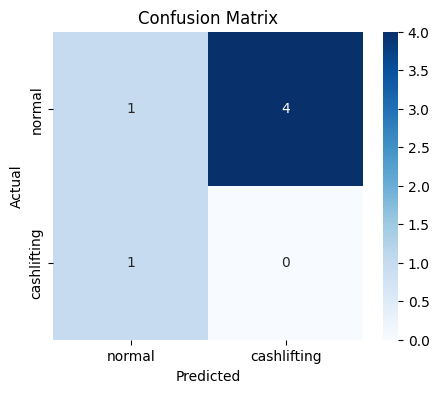

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if not tf.config.list_physical_devices('GPU'):
    print("⚠️ WARNING: No GPU found. Training will be slow.")

# Build model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(2, activation="softmax")
])

model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

print("🚀 Starting training...")
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

# Save model
model.save("/content/cashlifting_classifier.h5")
print("💾 Model saved as /content/cashlifting_classifier.h5")

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["normal", "cashlifting"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["normal", "cashlifting"], yticklabels=["normal", "cashlifting"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Testing the code

In [16]:
# =========================
#  TEST ON A SINGLE VIDEO
# =========================

def predict_single_video(video_path, model, target_size=(128, 128)):
    import cv2
    if not os.path.exists(video_path):
        print(f"File not found: {video_path}")
        return

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(" Could not read frame from video.")
        return

    # Preprocess
    frame = cv2.resize(frame, target_size)
    frame = np.expand_dims(frame, axis=0).astype("float32")
    frame = preprocess_input(frame)

    # Predict
    pred = model.predict(frame)
    class_idx = np.argmax(pred, axis=1)[0]
    class_names = ["normal", "cashlifting"]
    confidence = pred[0][class_idx] * 100

    print(f" Prediction: {class_names[class_idx]} ({confidence:.2f}% confidence)")

# Example usage:
test_video_path = "/content/cashlifting_mp4/cctv_CAM 5_main_20250524212350.mp4"
predict_single_video(test_video_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
🎯 Prediction: cashlifting (75.98% confidence)


In [17]:
# =========================
# 📌 TEST ON A SINGLE VIDEO
# =========================

def predict_single_video(video_path, model, target_size=(128, 128)):
    import cv2
    if not os.path.exists(video_path):
        print(f"❌ File not found: {video_path}")
        return

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("❌ Could not read frame from video.")
        return

    # Preprocess
    frame = cv2.resize(frame, target_size)
    frame = np.expand_dims(frame, axis=0).astype("float32")
    frame = preprocess_input(frame)

    # Predict
    pred = model.predict(frame)
    class_idx = np.argmax(pred, axis=1)[0]
    class_names = ["normal", "cashlifting"]
    confidence = pred[0][class_idx] * 100

    print(f"🎯 Prediction: {class_names[class_idx]} ({confidence:.2f}% confidence)")

# Example usage:
test_video_path = "/content/cashlifting_mp4/cctv_CAM 5_main_20250524212319.mp4"
predict_single_video(test_video_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🎯 Prediction: normal (81.67% confidence)
